# Chapter 13 Interpretability

In [23]:
# Python imports
import os
from dotenv import load_dotenv
import random
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning - scikit-learn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import auc, make_scorer, mean_absolute_error, mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay


# Machine learning - XGBoost
import xgboost as xgb

# Package for LIME interpretation
import lime                                    
import lime.lime_tabular

import tqdm
import shap 

In [2]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # for classification

In [3]:
# Recreate variables done in notebooks 4 and 5
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]


X_short = data_ml[features_short]
X_short_train = training_sample[features_short]
y_short_train = training_sample['R1M_Usd'].values
X_short_test = testing_sample[features_short]
y_short_test = testing_sample['R1M_Usd'].values


y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features]
X_test = testing_sample[features]
y_test = testing_sample['R1M_Usd'].values

# For XGBoost model
separation_mask = data_ml['date'] < separation_date
data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values
boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values
train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!

y_penalized = data_ml['R1M_Usd'].values # Dependent variable
X_penalized = data_ml[features].values # Predictors
y_penalized_train = training_sample['R1M_Usd'].values # Dependent variable
X_penalized_train = training_sample[features].values # Predictors

In [4]:
fit_RF = RandomForestRegressor(
    n_estimators = 40, # Nb of random trees
    criterion ='squared_error', # function to measure the quality of a split
    min_samples_split= 250, # Minimum size of terminal cluster
    bootstrap=True, # replacement
    max_features=30, # Nb of predictive variables for each tree
    max_samples=10000 # Size of (random) sample for each tree
)

fit_RF.fit(X_short_train, y_short_train) # Fitting the model
fit_RF.predict(pd.DataFrame(X_short_test).iloc[0:5,]) # Prediction over the first 5 test instances 

array([0.13610365, 0.11815935, 0.11815935, 0.11611578, 0.13335534])

## 13.1 Global interpretations
### 13.1.1 Simple models as surrogate

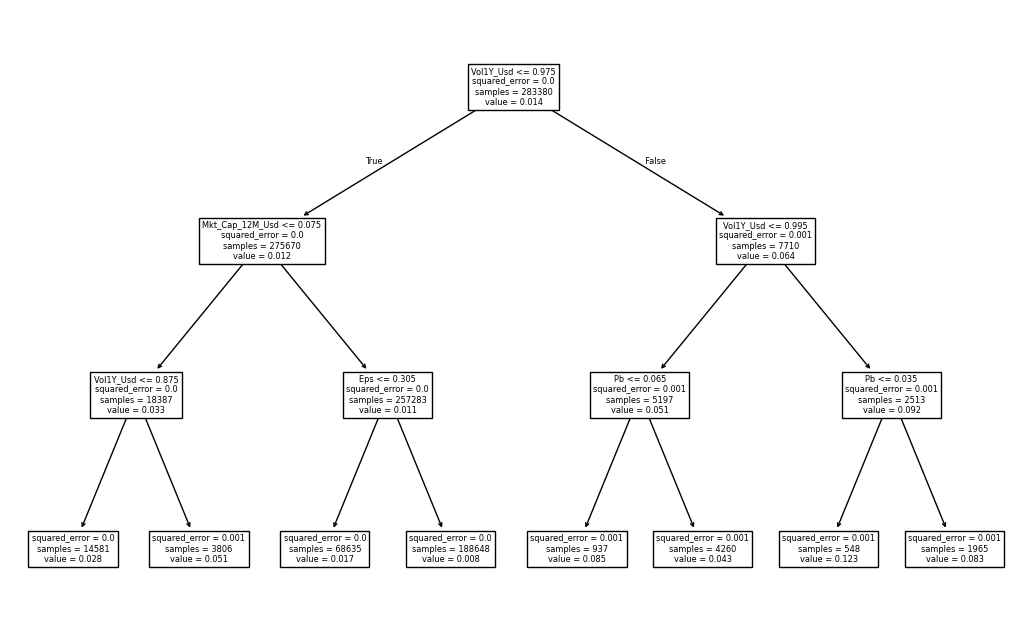

In [5]:
new_target = fit_RF.predict(X_short)                                                    # saving the predictions of tree as new target
decision_tree_model = tree.DecisionTreeRegressor(max_depth=3)                           # defining the global interpretable tree surrogate model
TreeSurrogate=decision_tree_model.fit(X_short,new_target)               # fitting the surrogate
fig, ax = plt.subplots(figsize=(13, 8))                                                 # setting the chart parameters
tree.plot_tree(TreeSurrogate,feature_names=features_short, ax=ax) 
plt.show()                                                                              # Plot!

In [6]:
fit_tree = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 8000, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth (i.e. tree levels)
  ccp_alpha = 0.000001, # complexity parameters
  min_samples_leaf = 3500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree.fit(X_short_train, y_short_train) # Fitting the model

mono_const="(0, 0, -1, 1, 0, -1, 0)" # Initialize the vector -- "-1" == decreasing, "+1" increasing 
# Decreasing in market cap -- mono_const[2]
# Increasing in past return -- mono_const[3]
# Decreasing in price-to-book -- mono_const[5]

params = {
    # General Booster Parameters
    'booster' : 'dart',         # Explicitly set to DART to enable 'rate_drop'
    'objective' : "reg:squarederror", # Objective function
    'eta' : 0.3,               # Learning rate
    
    # Tree Structure and Pruning
    'max_depth' : 4,            # Max depth of each tree
    'gamma' : 0.1,              # Penalization of number of leaves (pruning).
    'lambda' : 1.0,             # L2 regularization on leaf weights (w^2)
    'monotone_constraints' : mono_const, # Monotonicity constraints

    # Subsampling/Regularization
    'subsample' : 0.6,          # Train on random 60% of sample
    'colsample_bytree' : 0.7,   # Train on random 70% of predictors

    # DART Specific Parameters
    'rate_drop' : 0.1,          # Dropout rate for DART
    'skip_drop' : 0.5,          # Probability of skipping the dropout procedure for DART
}

fit_xgb =xgb.train(params, train_matrix_xgb)

<Axes: >

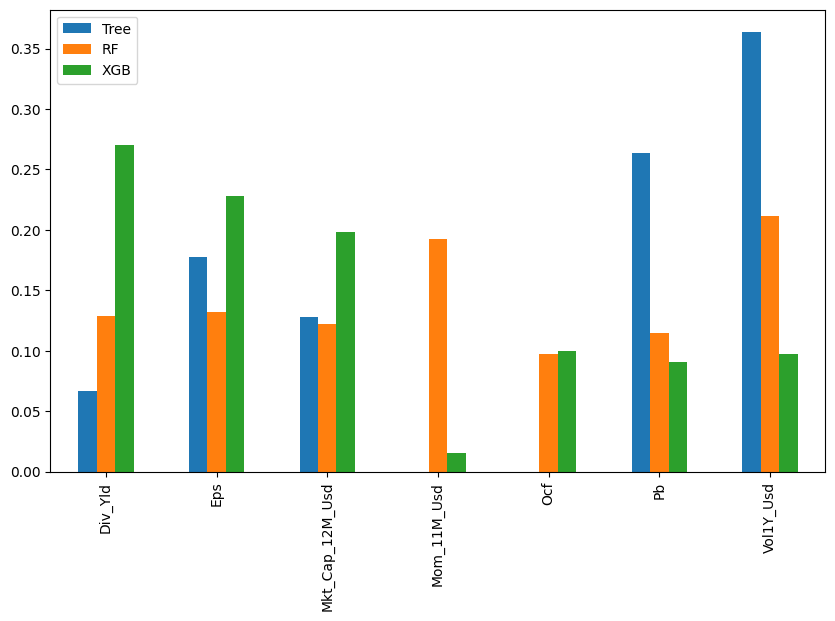

In [7]:
# Get feature importances from XGBoost Booster
xgb_importances = fit_xgb.get_score(importance_type='total_gain')
# Align importances with features_short
xgb_importances_list = [xgb_importances.get(f, 0) for f in features_short]

tree_VI = pd.DataFrame(data=fit_tree.feature_importances_,index=features_short,columns=['Tree'])    # VI from tree model
RF_VI = pd.DataFrame(data=fit_RF.feature_importances_,index=features_short,columns=['RF'])          # VI from random forest
XGB_VI = pd.DataFrame(data=xgb_importances_list, index=features_short, columns=['XGB'])  # VI from boosted trees
VI_trees=pd.concat([tree_VI,RF_VI,XGB_VI],axis=1)                                                   # Aggregate the VIs
VI_trees=VI_trees/np.sum(VI_trees, axis=0)
VI_trees.plot.bar(figsize=[10,6])                                                                   # Plotting sequence

### 13.1.3 Variable importance (agnostic)

In [8]:
fit_ridge_0 = Ridge(alpha=0.01)                                                         # Trained model
fit_ridge_0.fit(X_penalized_train, y_penalized_train)                                   # Fit model
l_star= np.mean(np.square(fit_ridge_0.predict(X_penalized_train)-y_penalized_train))    # Loss

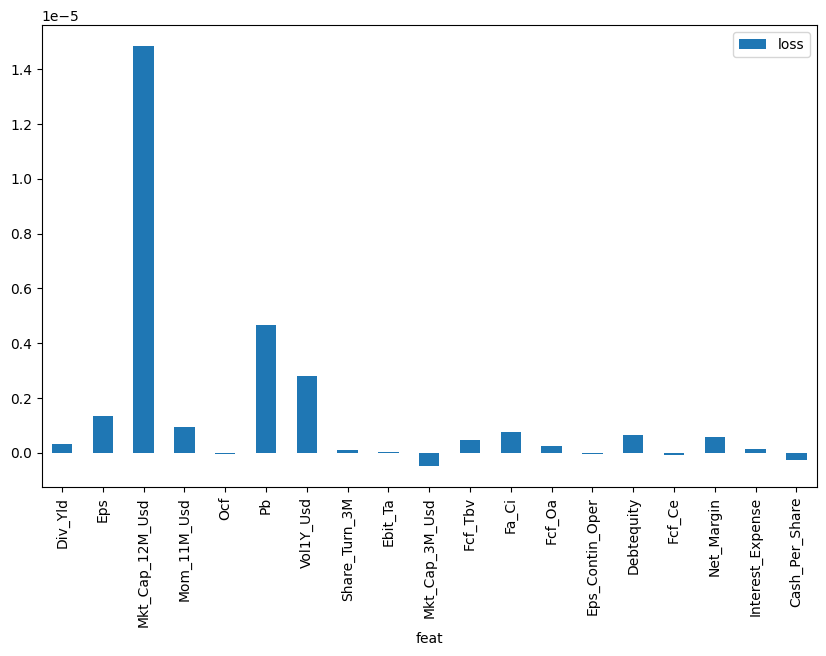

In [9]:
res = []                                                                                                     # Initialize
feature_random = random.sample(list((Counter(features)-Counter(features_short)).elements()), 12)             # selecting fewer features for computation time sake
for feat in (features_short+feature_random):                                                                 # Loop on the features
    temp_data=training_sample[features].copy()                                                               # temp dataframe for all features
    temp_data.loc[:,feat] = np.random.permutation(training_sample[feat])                                     # shuffling for feat[i]
    fit_ridge_0.fit(temp_data[features], training_sample['R1M_Usd'])                                         # fitting the model 
    result_VI=pd.DataFrame([feat],columns=['feat'])
    result_VI['loss']=[np.mean(np.square(fit_ridge_0.predict(temp_data[features])-training_sample['R1M_Usd'])) - l_star] # Loss
    res.append(result_VI)                                                                                    # appending through features loop
res = pd.concat(res)
res.set_index('feat',inplace=True)

res.plot.bar(figsize=[10,6])
plt.show()

### 13.1.4 Partial dependence plot

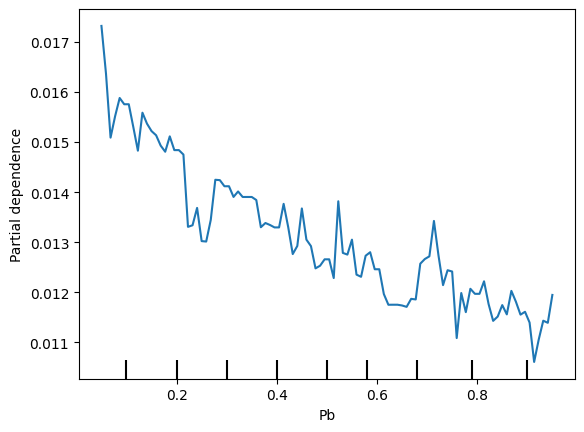

In [10]:
PartialDependenceDisplay.from_estimator(fit_RF,training_sample[features_short], ['Pb'],kind='average')
plt.show()

## 13.2 Local interpretations
### 13.2.1 LIME

In [16]:
xgb_model = xgb.XGBRegressor(              # Parameters of the boosted tree
    max_depth=5,                               # Max depth of each tree
    learning_rate=0.5,                         # Learning rate
    objective='reg:squarederror',              # booster type of objective function
    subsample=1,                               # Proportion of instance to be sampled (1 = all)
    colsample_bytree=1,                        # Proportion of predictors to be sampled (1 = all)
    gamma=0.1,                                 # Penalization
    n_estimators=10,                           # Number of trees
    min_child_weight=10)                       # Min number of instances in each node

xgb_model.fit(train_features_xgb, train_label_xgb) # Training of the model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_features_xgb.values,     # values in tabular i.e. Matrix
                                                   mode='regression',             # “classification” or “regression”
                                                   feature_names=train_features_xgb.columns,
                                                   verbose=1)                     # if true, print local prediction values from linear model

exp = explainer.explain_instance(train_features_xgb.iloc[0,:].values,                   # First instance in train_sample 
                                 predict_fn=xgb_model.predict,                          # prediction function
                                 distance_metric='euclidean',                           # Dist.func. "gower" is one alternative
                                 num_samples=900,                                       # Nb samples for loss function
                                 num_features=6)                                        # Nb of features shown (important ones)

from IPython.display import display, HTML
display(HTML(exp.as_html()))

Intercept 0.01006691194367033
Prediction_local [0.03718325]
Right: 0.020587575


### 13.2.2 Shapley values

In [20]:
fit_RF_short = RandomForestRegressor(n_estimators=40,             # Nb of random trees
                                     criterion='squared_error',   # function to measure the quality of a split
                                       min_samples_leaf=250,      # Minimum size of terminal cluster
                                       max_features=4,            # Nb of predictive variables for each tree
                                       bootstrap=True,            # No replacement
                                       max_samples=10000)         # Size of (random) sample for each tree
 
fit_RF_short.fit(training_sample[features_short],training_sample['R1M_Usd'].values) # fitting the model

,n_estimators,40
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,250
,min_weight_fraction_leaf,0.0
,max_features,4
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


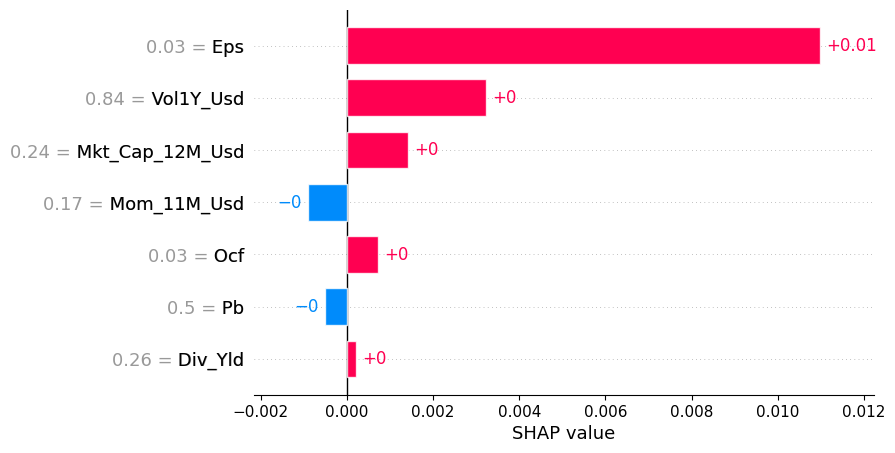

In [ ]:
explainer = shap.explainers.Exact(fit_RF_short.predict,                       # Compute the Shapley values...
                                  training_sample[features_short],            # Training data as DataFrame
                                  feature_names=features_short)               # features names, could be passed by the predictor fn as well
shap_values = explainer(training_sample[features_short].iloc[:1])            # On the first instance as DataFrame
shap.plots.bar(shap_values[0])                                                # Visual display